In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr
from eofs.xarray import Eof

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36371 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45289' processes=7 threads=14, memory=63.00 GiB>

In [3]:
#load in ctrl dataset
ctrl_ds = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl = ctrl_ds.sst.compute()

In [4]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] + 360) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [5]:
ctrl = roll_lon(ctrl)

In [6]:
exp_dir = "/scratch/e14/sm2435/archive/"

In [7]:
suffix = "/history/ocn/ocean_month.nc*"

In [8]:
Idea_list = ["df972", "df973", "df474", "df475", "df476", 'df477','df478','df479','df480', "df481"]

In [15]:
new_time = ctrl.time[0:18]

In [16]:
CP_list = ["df972",'df478','df479','df480', 'df481']
EP_list = [ "df973", "df474", "df475", "df476", 'df477']

In [17]:
CP_dict={}
for exp in CP_list:
    ds = xr.open_mfdataset(exp_dir+exp+suffix, use_cftime=True, chunks= {"time":12})
    sst = ds.sst[0:18]
    sst = roll_lon(sst)
    #change the time to 0000
    sst['time'] = new_time
    sst.coords['exp'] = exp
    CP_dict[exp] = sst

In [18]:
EP_dict={}
for exp in EP_list:
    ds = xr.open_mfdataset(exp_dir+exp+suffix, use_cftime=True, chunks= {"time":12})
    sst = ds.sst[0:18]
    sst = roll_lon(sst)
    #change the time to 0000
    sst['time'] = new_time
    sst.coords['exp'] = exp
    EP_dict[exp] = sst

In [19]:
def roll_lon_u(df):
    df.coords['xu_ocean'] = (df.coords['xu_ocean'] + 360) % 360# - 180
    df = df.sortby(df.xu_ocean)
    return df

In [20]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def DMI_ctrl(DS):
    WTIO =  ssta(DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO =  ssta(DS).sel(yt_ocean=slice(
         -10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO - SETIO)

def DMI_exp(DS):
    WTIO =  (DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO =  (DS).sel(yt_ocean=slice(
         -10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO - SETIO)

In [21]:
def SE_exp(DS):
    SETIO =  (DS).sel(yt_ocean=slice(
         -10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (SETIO)

In [22]:
def WT_exp(DS):
    WTIO =  (DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO)

In [23]:
def IOBM(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -20, 20),xt_ocean=slice(40,110)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [24]:
def NINO3(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(210, 270)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [25]:
def NINO34(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(190, 240)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [26]:
def NINO4(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(160, 210)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [27]:
def get_IOD_members_IDX(EXP, TH, index):
    DMI = DMI_exp(EXP)
    IDX = index(EXP)
    #look between July and december
    TS = DMI.sel(time=slice("0950-06-01", "0950-12-31"))
    TS2 = IDX.where(TS.exp == TS.where(TS>=TH, drop =True).exp)
    return TS2

In [28]:
idea_ds = xr.concat(idea_dict.values(), dim='exp')

NameError: name 'idea_dict' is not defined

In [ ]:
idea_ds_anom = idea_ds.groupby("time.month") - ctrl.groupby("time.month").mean("time")


In [29]:
EP_ds = xr.concat(EP_dict.values(), dim='exp')
EP_ds_anom = EP_ds.groupby("time.month") - ctrl.groupby("time.month").mean("time")


In [30]:
CP_ds = xr.concat(CP_dict.values(), dim='exp')
CP_ds_anom = CP_ds.groupby("time.month") - ctrl.groupby("time.month").mean("time")


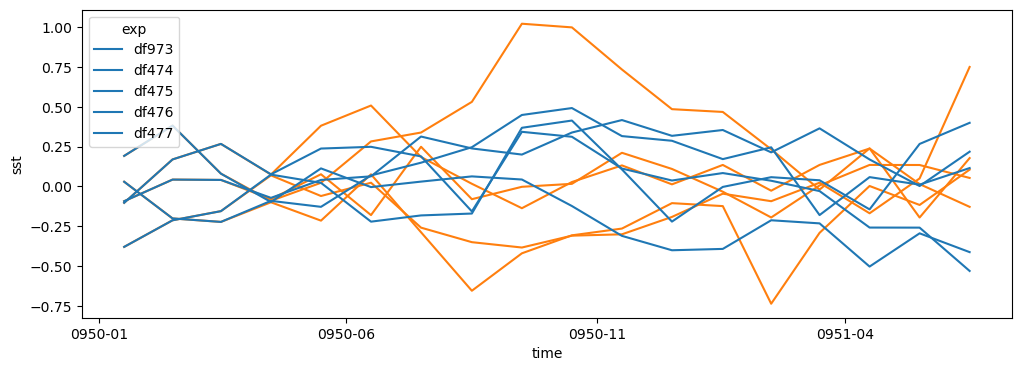

In [31]:
DMI_exp(CP_ds_anom).plot(hue = "exp", c = "tab:orange", figsize = (12,4))
DMI_exp(EP_ds_anom).plot(hue = "exp", c = "tab:blue")

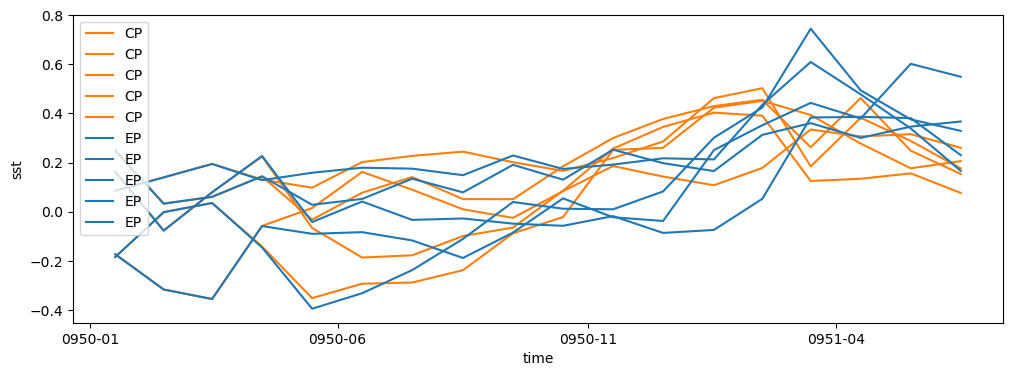

In [32]:
IOBM(CP_ds_anom).plot(hue = "exp", c = "tab:orange", figsize = (12,4), label = "CP")
IOBM(EP_ds_anom).plot(hue = "exp", c = "tab:blue", label = "EP")
plt.legend()

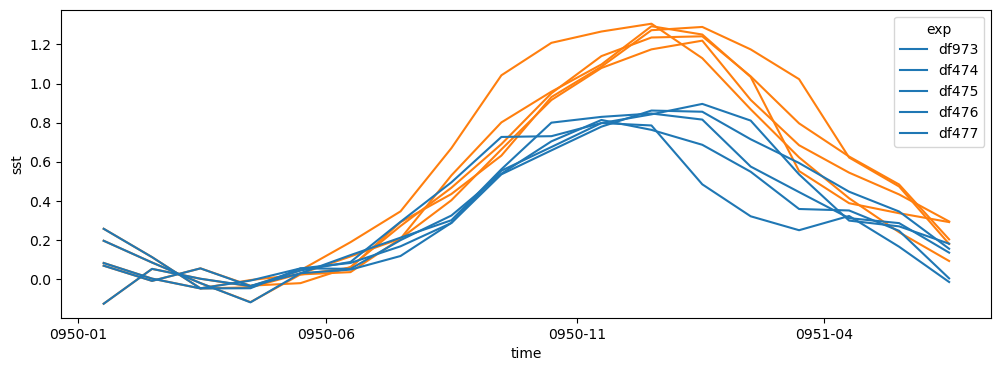

In [33]:
NINO34(CP_ds_anom).plot(hue = "exp", c = "tab:orange", figsize = (12,4))
NINO34(EP_ds_anom).plot(hue = "exp", c = "tab:blue")

In [ ]:
DMI_exp(idea_ds_anom).plot(hue = "exp", figsize = (12,4))

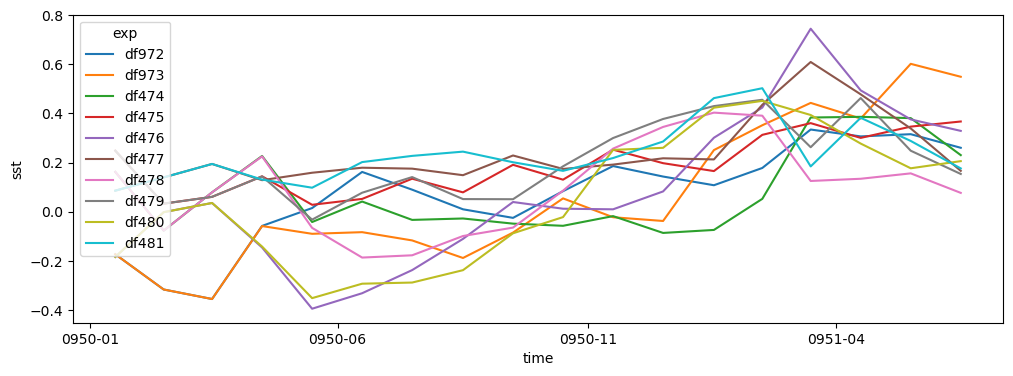

In [25]:
IOBM(idea_ds_anom).plot(hue = "exp", figsize = (12,4))

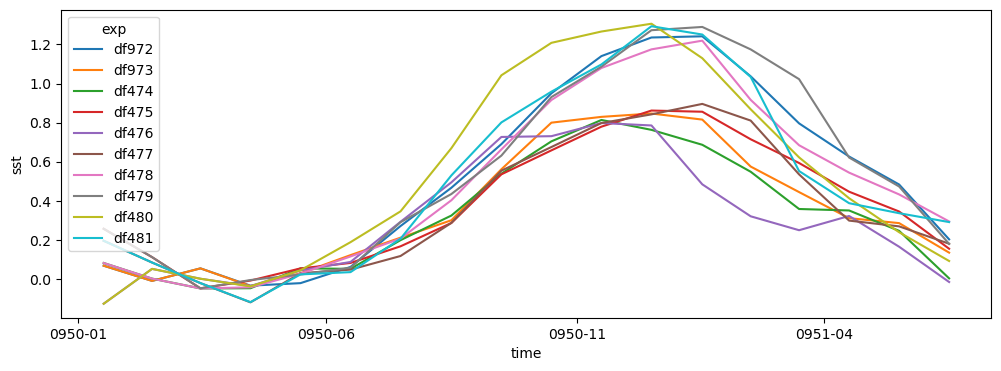

In [26]:
NINO34(idea_ds_anom).plot(hue = "exp", figsize = (12,4))

In [21]:
EPu = idea_dict_wind['df440']
CPu = idea_dict_wind['df442']


In [83]:
EP = idea_dict['df973']
CP = idea_dict['df972']


In [84]:
EPa = EP.groupby("time.month") - ctrl.groupby("time.month").mean("time")
CPa = CP.groupby("time.month") - ctrl.groupby("time.month").mean("time")

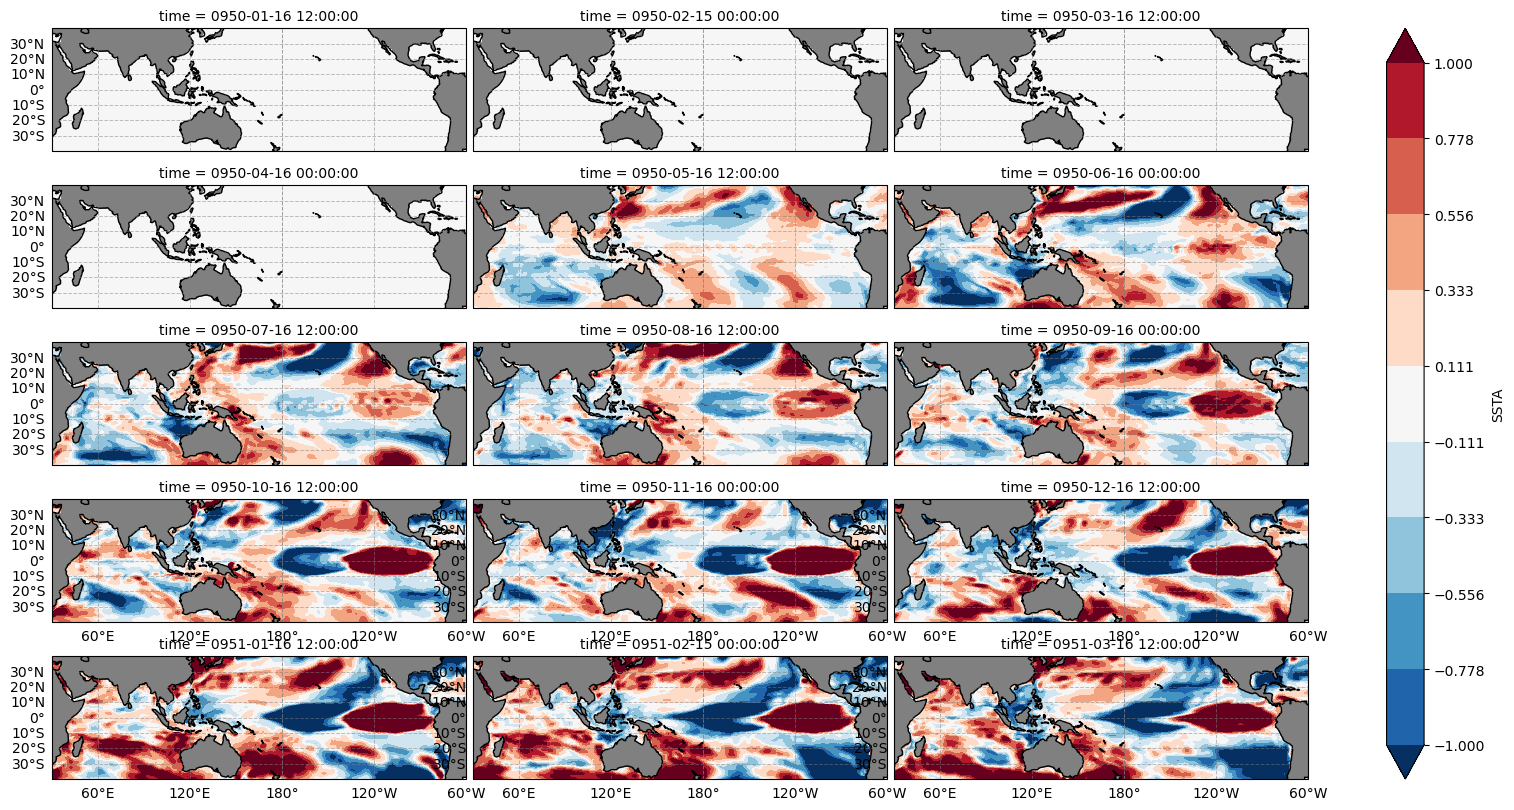

In [89]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = (EPa-CPa)[0:15].plot.contourf(col="time", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -1, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SSTA'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7,8]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False 

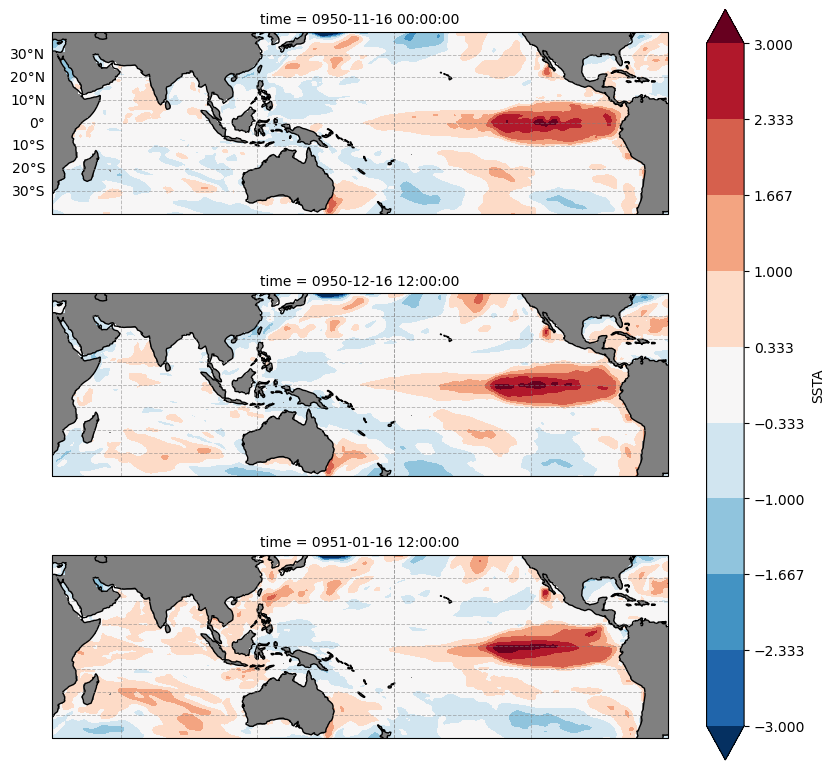

In [280]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = EPa[10:13].plot.contourf(col="time", col_wrap = 1, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(8,8), vmin = -3, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SSTA'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7,8]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

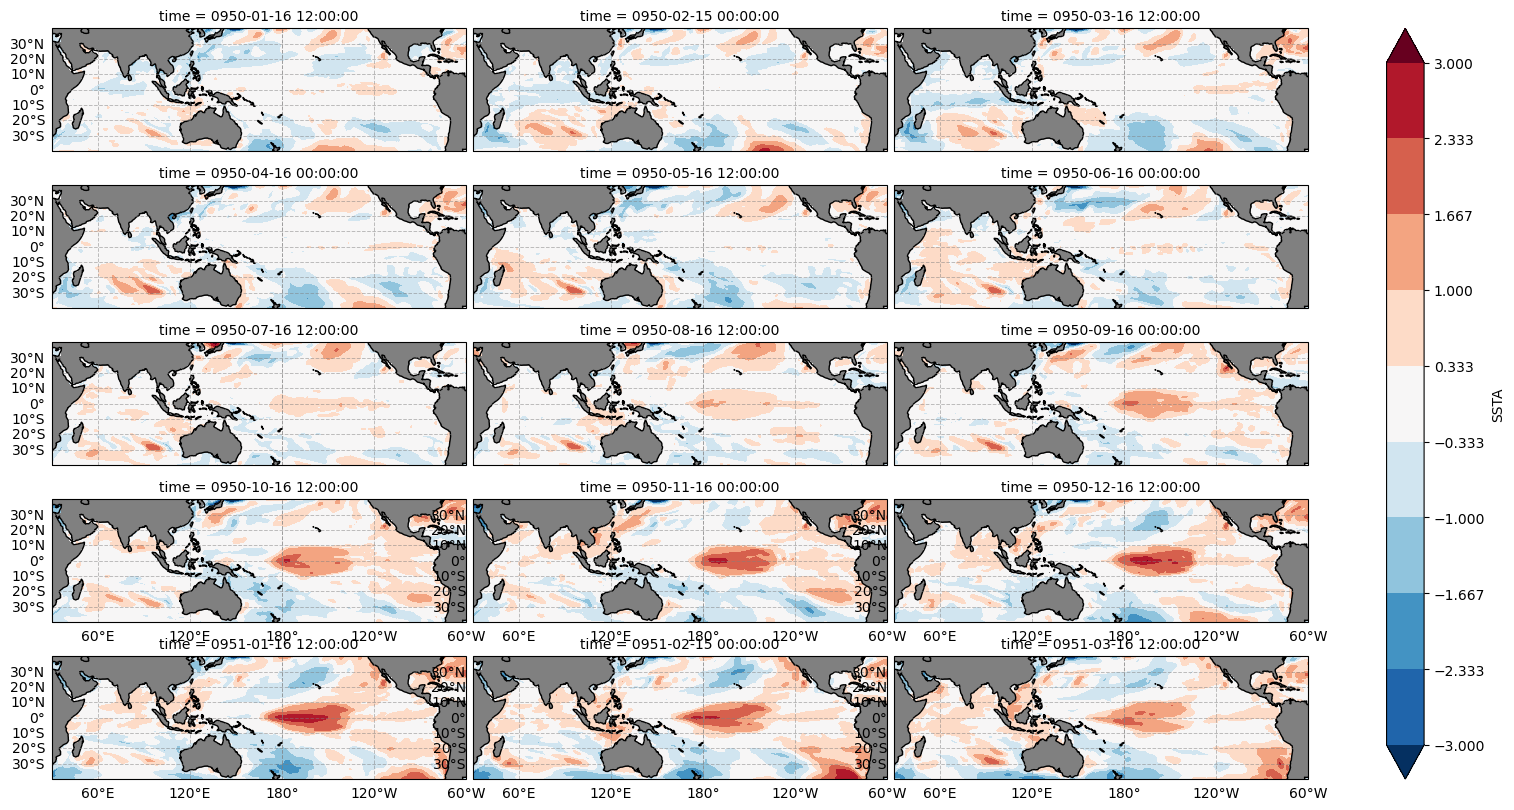

In [91]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = CPa[0:15].plot.contourf(col="time", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -3, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SSTA'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5,6,7,8]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [92]:
#look at IOD

Text(0.5, 1.0, 'DMI')

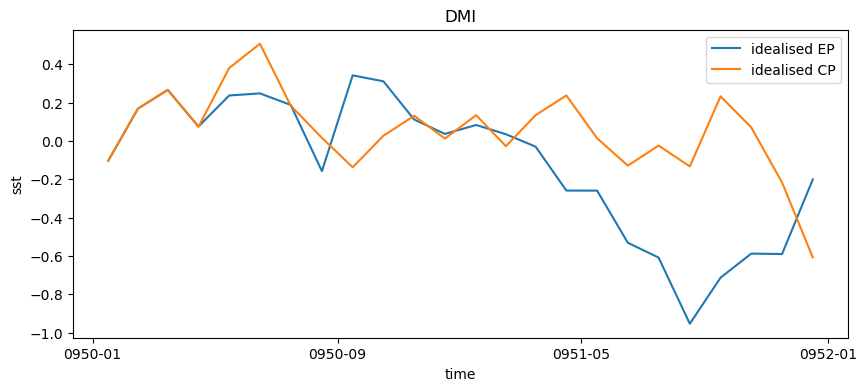

In [93]:
plt.figure(figsize = (10,4))
DMI_exp(EPa).plot(label = "idealised EP")
DMI_exp(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("DMI")

Text(0.5, 1.0, 'SETIO')

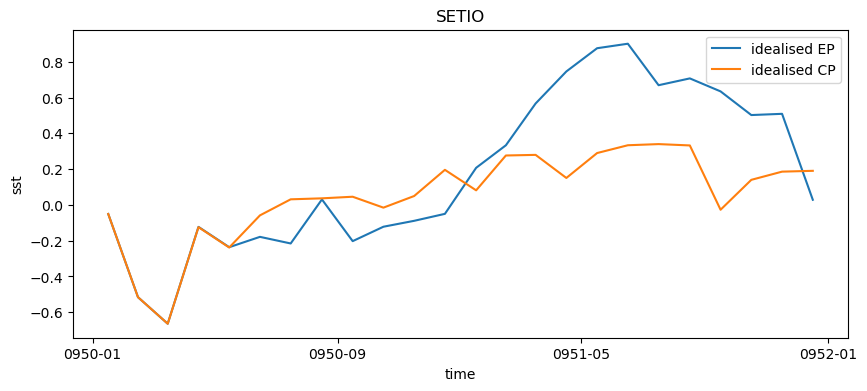

In [94]:
plt.figure(figsize = (10,4))
SE_exp(EPa).plot(label = "idealised EP")
SE_exp(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("SETIO")

Text(0.5, 1.0, 'WTIO')

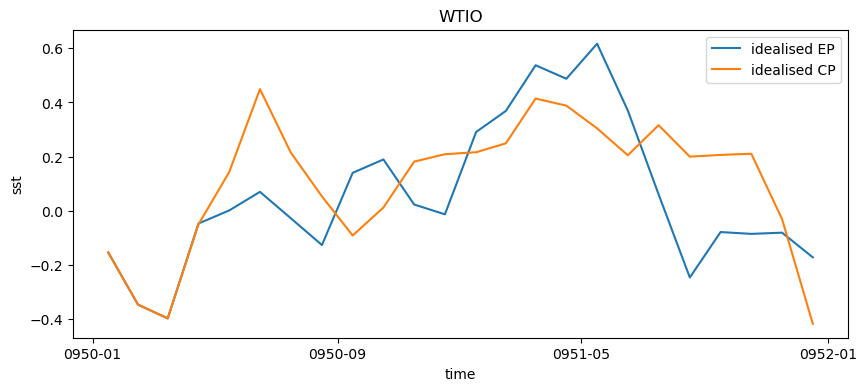

In [95]:
plt.figure(figsize = (10,4))
WT_exp(EPa).plot(label = "idealised EP")
WT_exp(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("WTIO")

Text(0.5, 1.0, 'Nino4')

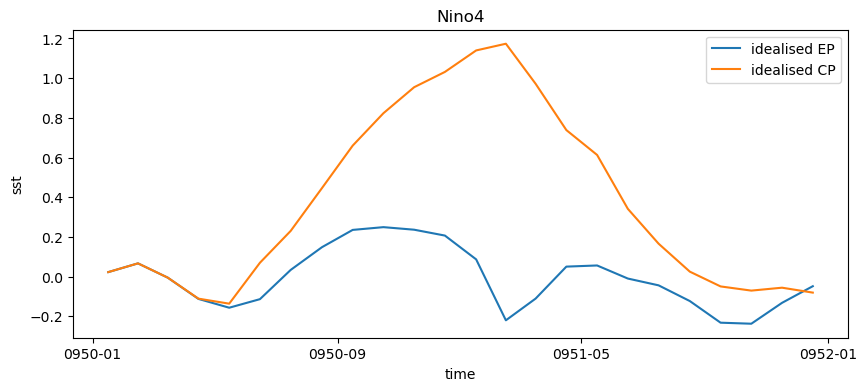

In [96]:
plt.figure(figsize = (10,4))
NINO4(EPa).plot(label = "idealised EP")
NINO4(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("Nino4")

Text(0.5, 1.0, 'Nino3')

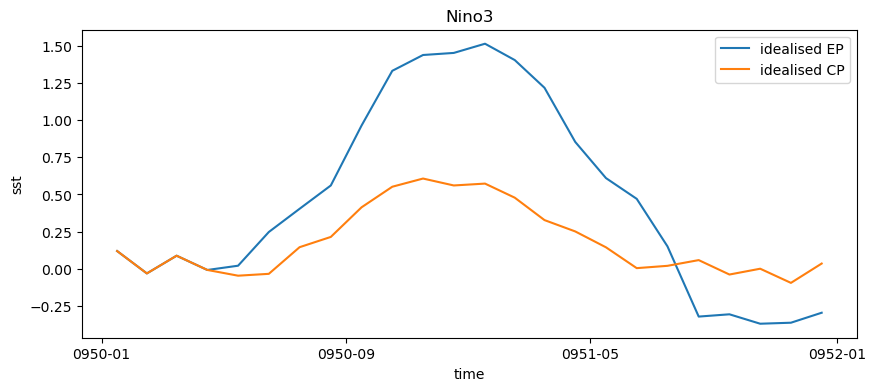

In [97]:
plt.figure(figsize = (10,4))
NINO3(EPa).plot(label = "idealised EP")
NINO3(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("Nino3")

Text(0.5, 1.0, 'Nino34')

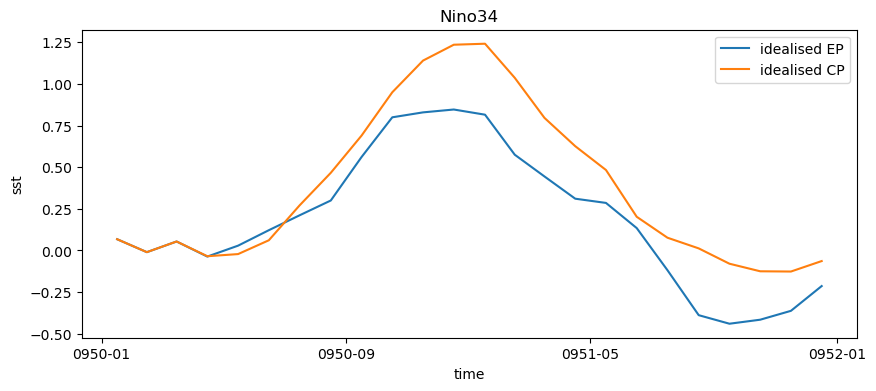

In [98]:
plt.figure(figsize = (10,4))
NINO34(EPa).plot(label = "idealised EP")
NINO34(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("Nino34")

Text(0.5, 1.0, 'IOBM')

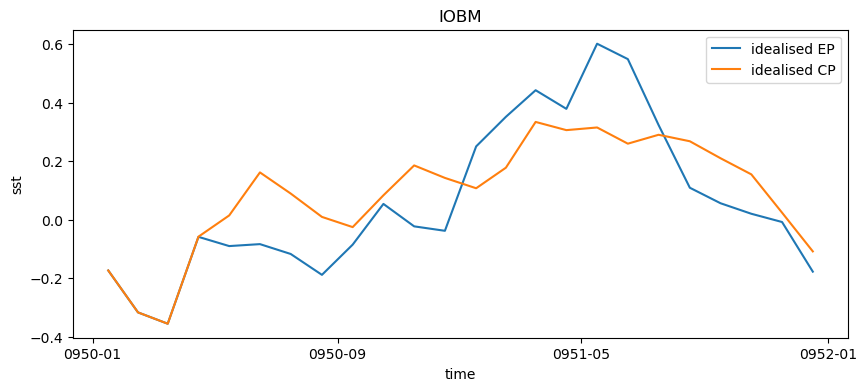

In [99]:
plt.figure(figsize = (10,4))
IOBM(EPa).plot(label = "idealised EP")
IOBM(CPa).plot(label = "idealised CP")
plt.legend()
plt.title("IOBM")

In [37]:
#look at wind patterns

In [100]:
#load in in daily SST and plot the anomaly

In [181]:
EPd1 = xr.open_mfdataset("/scratch/e14/sm2435/archive/df440/history/ocn/ocean_daily.nc-*", use_cftime=True)
CPd1 = xr.open_mfdataset("/scratch/e14/sm2435/archive/df442/history/ocn/ocean_daily.nc-*", use_cftime=True)

In [182]:
EPd = xr.open_mfdataset("/scratch/e14/sm2435/archive/df973/history/ocn/ocean_daily.nc-*", use_cftime=True)
CPd = xr.open_mfdataset("/scratch/e14/sm2435/archive/df972/history/ocn/ocean_daily.nc-*", use_cftime=True)
daily_clim = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/daily_sst_restoring_cm000_climatology_0951-1150.nc", decode_times = False)


In [183]:
EPd = EPd.sst
CPd = CPd.sst
EPd1 = EPd1.sst
CPd1 = CPd1.sst


In [184]:
daily_clim = daily_clim.temp[0].drop("DEPTH1_1")

In [185]:
daily_clim = daily_clim.rename({"GRID_X_T":"xt_ocean", "GRID_Y_T":"yt_ocean", "TIME":"dayofyear"})

In [230]:
def NINO3(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(-140, -80)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [263]:
def NINO4(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(-170, -150)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [188]:
def NINO34(DS):
    N4 =  (DS).sel(yt_ocean=slice(
         -10, 10),xt_ocean=slice(-170, -120)).mean(['yt_ocean', 'xt_ocean'])
    return N4

In [240]:
dec1 = cftime.DatetimeProlepticGregorian(990, 12, 16)
dec12 = cftime.DatetimeProlepticGregorian(990, 12, 22)
dec13 = cftime.DatetimeProlepticGregorian(990, 12, 28)
dec14 = cftime.DatetimeProlepticGregorian(991, 2, 15)
dec15 = cftime.DatetimeProlepticGregorian(991, 3, 15)
dec16 = cftime.DatetimeProlepticGregorian(991, 1, 15)
jan16 = cftime.DatetimeProlepticGregorian(991, 1, 16)


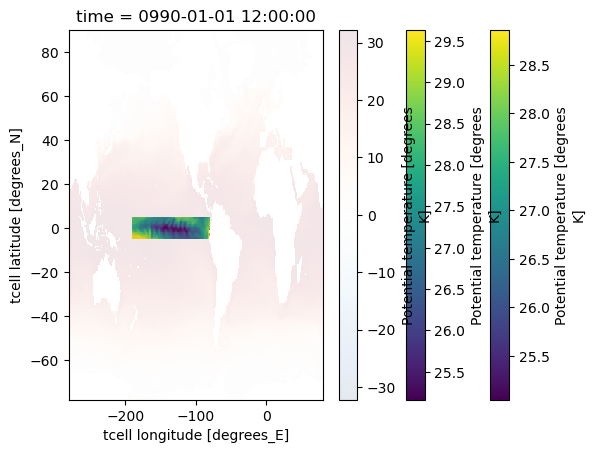

In [262]:
(CPd[0]).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(-120, -80)).plot()
(CPd[0]).sel(yt_ocean=slice(
         -5, 5),xt_ocean=slice(-190, -130)).plot()
CPd[0].plot(alpha = 0.1)


In [ ]:
plt.figure(figsize = (10,4))
NINO4(CPd).sel(time = slice("0990-12-01", "0991-01-31")).plot(label = "correct interpolation")


Text(0.5, 1.0, 'Restored SSTA in Nino3 region for EP experiments')

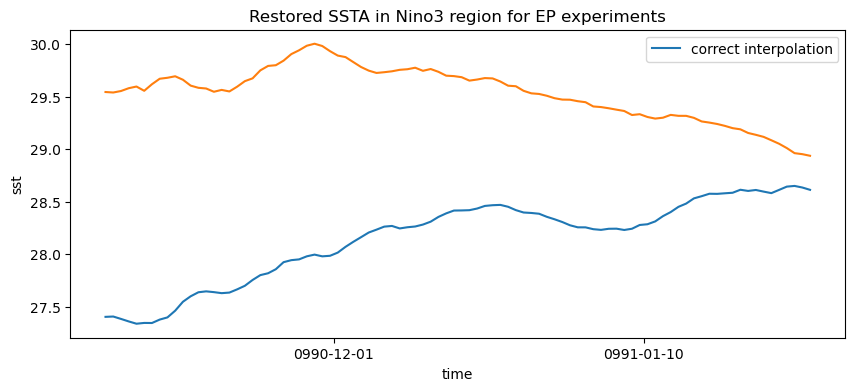

In [278]:
plt.figure(figsize = (10,4))
NINO3(EPd1).sel(time = slice("0990-11-01", "0991-01-31")).plot(label = "correct interpolation")
NINO4(CPd1).sel(time = slice("0990-11-01", "0991-01-31")).plot()
#NINO4(CPd1).sel(time = slice("0990-11-01", "0991-01-31")).plot(label = "wrong interpolation")
#NINO4(CPd1.groupby("time.dayofyear") - daily_clim).sel(time = slice("0990-12-01", "0991-01-31")).plot()
#plt.axvline(dec1, c= 'k', lw = 0.5,  linestyle='--')  
#plt.axvline(dec12, c= 'k', lw = 0.5,  linestyle='--')  
#plt.axvline(dec13, c= 'k', lw = 0.5,  linestyle='--')  
#plt.axvline(dec14, c= 'k', lw = 0.5,  linestyle='--')  
#plt.axvline(dec15, c= 'k', lw = 0.5,  linestyle='--')  
#plt.axvline(dec16, c= 'k', lw = 0.5,  linestyle='--')  
#plt.axvline(jan16, c= 'k', lw = 0.5,  linestyle='--')  
plt.legend()
plt.title("Restored SSTA in Nino3 region for EP experiments")

In [266]:
#laod in the new CP restore files

In [267]:
CP_jan01 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/Ideal_anom_CP/0990/Idealised_CP_anomaly_0990_01.nc", decode_times = False)
CP_jul01 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/Ideal_anom_CP/0990/Idealised_CP_anomaly_0990_07.nc", decode_times = False)

CP_jan02 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/Ideal_anom_CP/0990/Idealised_CP_anomaly_0991_01.nc", decode_times = False)
CP_jul02 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/Ideal_anom_CP/0990/Idealised_CP_anomaly_0991_07.nc", decode_times = False)

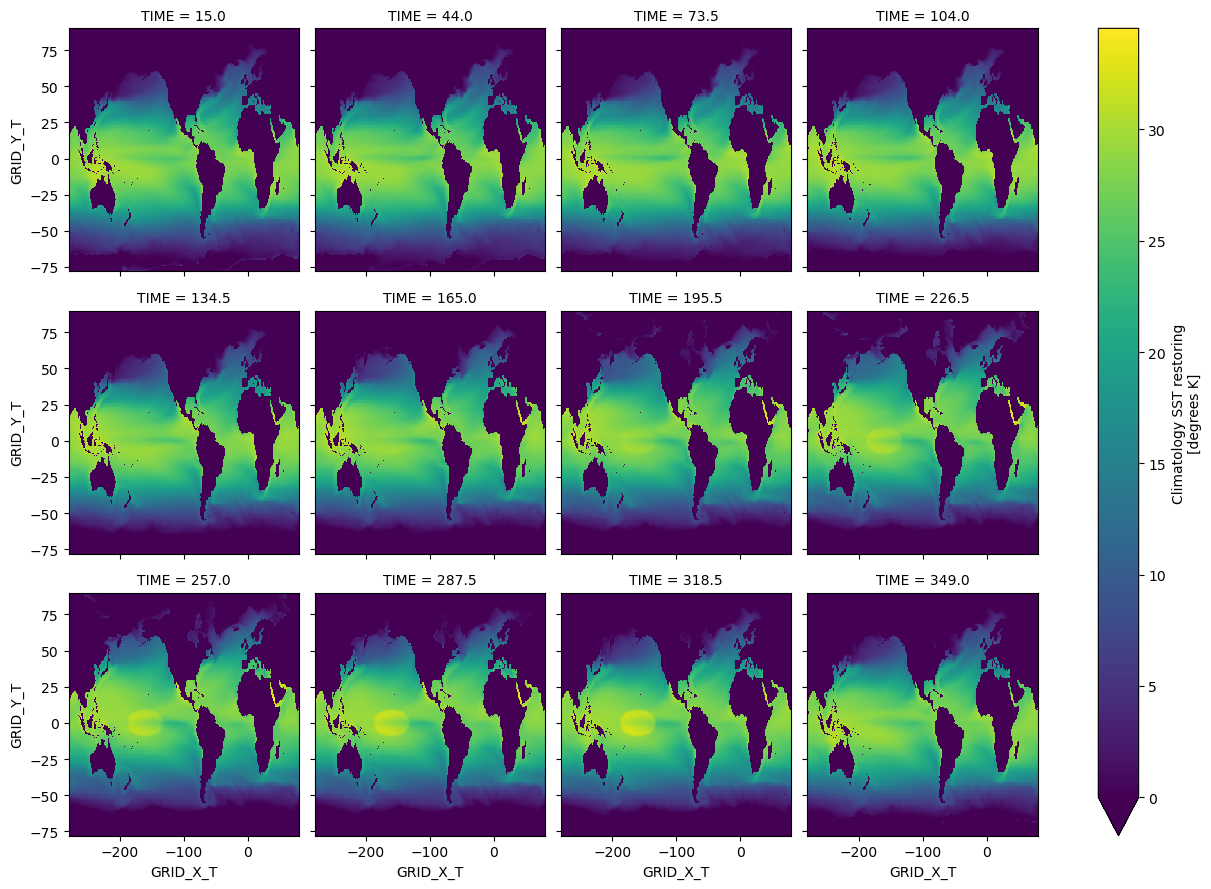

In [270]:
CP_jan01.temp.plot(col = "TIME", col_wrap = 4, vmin = 0)

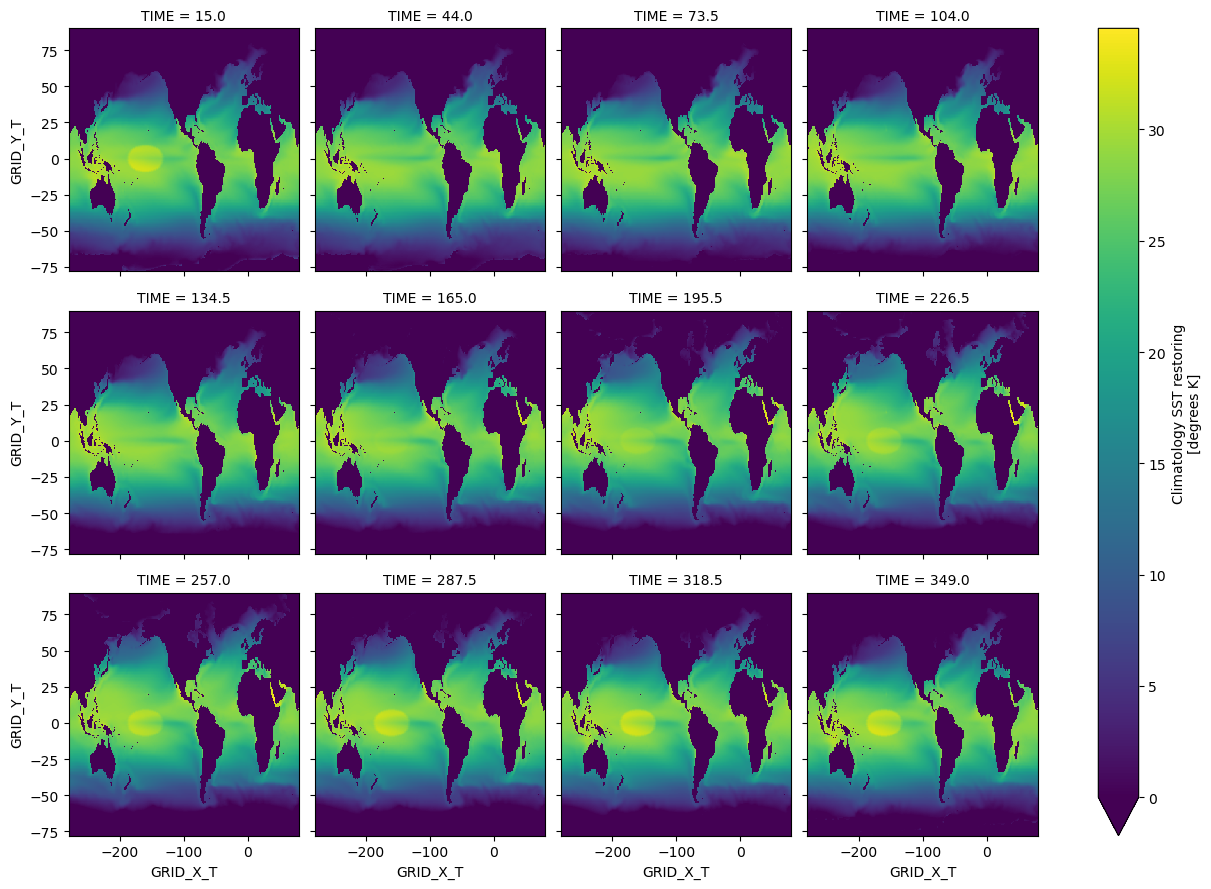

In [271]:
CP_jul01.temp.plot(col = "TIME", col_wrap = 4, vmin = 0)

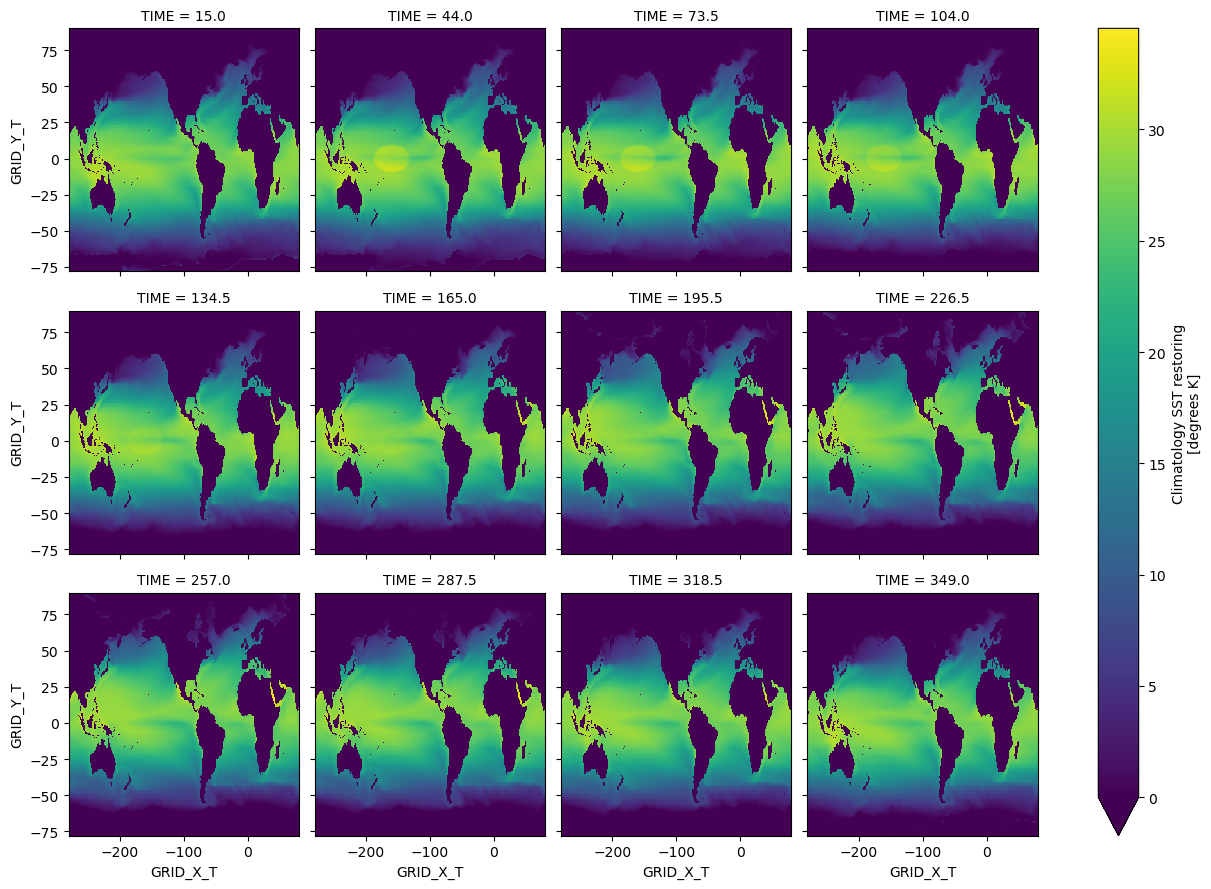

In [275]:
CP_jul02.temp.plot(col = "TIME", col_wrap = 4, vmin = 0)

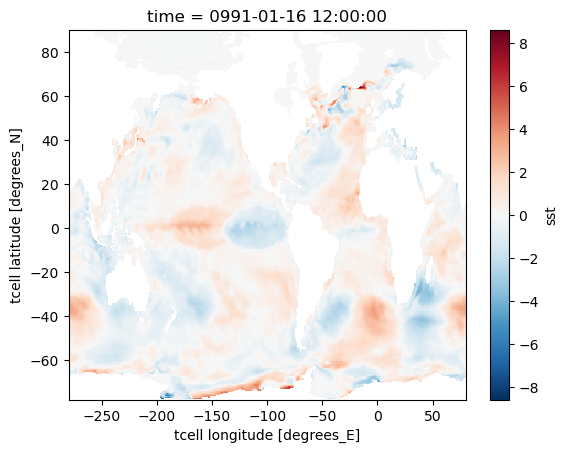

In [252]:
(CPd1 - EPd1)[380].plot()

In [281]:
#load in control daily for 3 years and cy286 daily for 3 years

In [292]:
cy286 = xr.open_mfdataset("/scratch/e14/sm2435/PACE_OC/cy286/history/ocn/ocean_daily.nc-095*", use_cftime = True, chunks = {"time" : 7})

In [293]:
cy286_3 = cy286.sst.sel(time = slice("0951-01-01", "0953-12-31"))

In [296]:
ctrl_950 = xr.open_mfdataset("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/ocean_daily.nc-095*", use_cftime=True, chunks = {"time" : 7})


In [297]:
ctrl_950_3 = ctrl_950.sst.sel(time = slice("0951-01-01", "0953-12-31"))

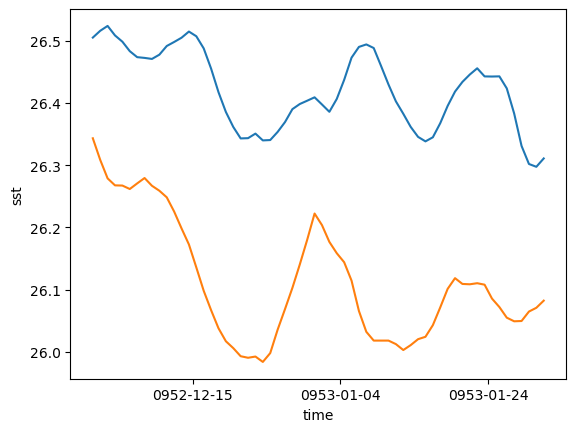

In [307]:
NINO34(ctrl_950_3).sel(time = slice("0952-12-01", "0953-01-31")).plot()
NINO34(cy286_3).sel(time = slice("0952-12-01", "0953-01-31")).plot()

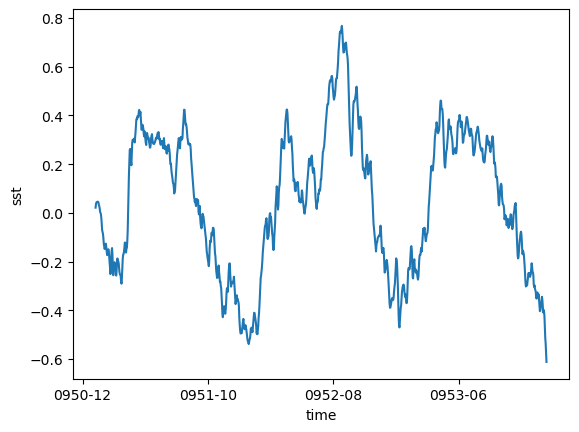

In [308]:
NINO34(cy286_3 - ctrl_950_3).plot()